# (Probabilistic) Noise2Void

This notebook is a re-implementation of the code for denoising with [noise2void](https://openaccess.thecvf.com/content_CVPR_2019/html/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.html) as proovided by the authors in this [repository](https://github.com/juglab/pn2v). Unlike the original code, this implementation uses pytorch instead of tensorflow. The key idea is to crop small tiles from image data, replace a given pixel with any other pixel in the tile and then try to predict the true intensity of the replaced pixel. Since the intensity of every pixel $i$ consists of two components noise $n$ and $s$ (intensity $i=n+s$), the network will inevitably fail to predict the noise component $n$ of the pixel - thus cleaning up the image in the process.

## Source code

Since the torch-implementation of noise2void is currently not (yet) pip-installlable, we simply clone the repository and import the functions provided therein.

In [27]:
!git clone https://github.com/juglab/pn2v.git

fatal: destination path 'pn2v' already exists and is not an empty directory.


In [28]:
import os
os.chdir('pn2v')

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import stackview

from unet.model import UNet
from pn2v import utils
from pn2v import training, prediction
import pn2v.histNoiseModel
from skimage import io

device=utils.getDevice()

CUDA available? True


## Dataset

As a training dataset, we'll use [this data](https://zenodo.org/record/5837363) of a developing tribolium embryo.

In [30]:
root = '/projects/p038/p_scads_trainings/BIAS/torch_segmentation_denoising_example_data/denoising_example_data'
if os.path.exists(root):
    data = io.imread(os.path.join(root, 'lund_i000000_oi_000000.tif'))
else:
    url = r'https://zenodo.org/record/5837363/files/lund_i000000_oi_000000.tif' 
    data = io.imread(url)

## Training

We next create the model:

In [31]:
# The N2V network requires only a single output unit per pixel
net = UNet(1, depth=3)

e:\BiAPoL\Projects\PoL-BioImage-Analysis-TS-GPU-Accelerated-Image-Analysis\docs\70_AI_Segmentation_Denoising\pn2v\unet\model.py:215: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
e:\BiAPoL\Projects\PoL-BioImage-Analysis-TS-GPU-Accelerated-Image-Analysis\docs\70_AI_Segmentation_Denoising\pn2v\unet\model.py:216: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


Noise2void provides the `training.trainNetwork` function to run the training. The essential parameters here are the following:

- `numOfEpochs`: number of epochs to train
- `numOfIterations`: number of steps in each epochs
- `patchSize`: size of the patches to extract from the images
- `batchSize`: number of patches to use in each iteration

In [32]:
model_directory = './model'
os.makedirs(model_directory, exist_ok = True)

In [33]:
# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=data, valData=data,
                                           postfix='conv_N2V', directory=model_directory, noiseModel=None,
                                           device=device, numOfEpochs=100, stepsPerEpoch=10, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3)

Epoch 0 finished      
avg. loss: 0.10178166944533587+-(2SEM)0.009077229520687513      
Epoch 1 finished      
avg. loss: 0.05427669202908873+-(2SEM)0.007266653925900008      
Epoch 2 finished      
avg. loss: 0.055269555933773515+-(2SEM)0.005832183151891591      
Epoch 3 finished      
avg. loss: 0.04591562105342746+-(2SEM)0.006076027517975671      
Epoch 4 finished      
avg. loss: 0.04633328560739756+-(2SEM)0.004488948674173996      
Epoch 5 finished      
avg. loss: 0.04821818303316831+-(2SEM)0.006612222493312421      
Epoch 6 finished      
avg. loss: 0.03981889635324478+-(2SEM)0.00640618087838512      
Epoch 7 finished      
avg. loss: 0.04316314794123173+-(2SEM)0.006777747177791484      
Epoch 8 finished      
avg. loss: 0.045798633620142935+-(2SEM)0.005792215109114235      
Epoch 9 finished      
avg. loss: 0.04436514610424638+-(2SEM)0.005698760310098421      
Epoch 10 finished      
avg. loss: 0.044780786521732806+-(2SEM)0.007313865793629464      
Epoch 11 finished      
avg. 

In [44]:
n2vResult = prediction.tiledPredict(data[40], net ,ps=256, overlap=48,
                                        device=device, noiseModel=None)

Text(0.5, 1.0, 'Noise2Void result')

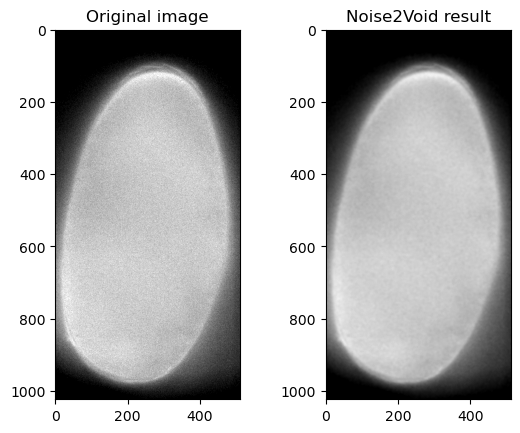

In [45]:
vmin = 150
vmax = 280

fig, axes = plt.subplots(ncols=2)

axes[0].imshow(data[40], cmap='gray', vmin=vmin, vmax=vmax)
axes[0].set_title('Original image')

axes[1].imshow(n2vResult, cmap='gray', vmin=vmin, vmax=vmax)
axes[1].set_title('Noise2Void result')

Text(0.5, 1.0, 'Noise2Void result')

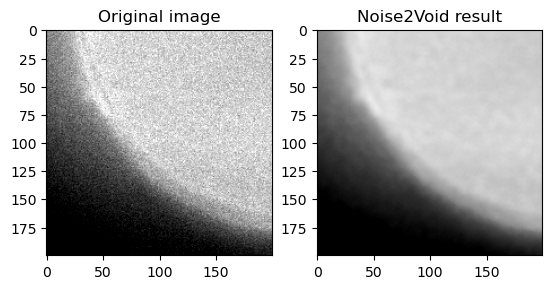

In [47]:
fig, axes = plt.subplots(ncols=2)

axes[0].imshow(data[40][800:1000, 0:200], cmap='gray', vmin=vmin, vmax=vmax)
axes[0].set_title('Original image')

axes[1].imshow(n2vResult[800:1000, 0:200], cmap='gray', vmin=vmin, vmax=vmax)
axes[1].set_title('Noise2Void result')

In [48]:
stackview.curtain(data[40][800:1000, 0:200], n2vResult[800:1000, 0:200], zoom_factor=2)

## Process 3D data

Noise2Void generally runs under the assumption, that the noise between neighboring pixels is un-correlated. This assumption is valid in both 3D and 2D. While the performance is probably worse than using a real 3D convolutional network, it is still legitimate too apply noise2void slice by slice to the data stack:

In [38]:
denoised_image = np.zeros_like(data)

for z in range(data.shape[0]):
    denoised_image[z] = prediction.tiledPredict(data[z], net ,ps=256, overlap=48,
                                        device=device, noiseModel=None)

Text(0.5, 1.0, 'Noise2Void result')

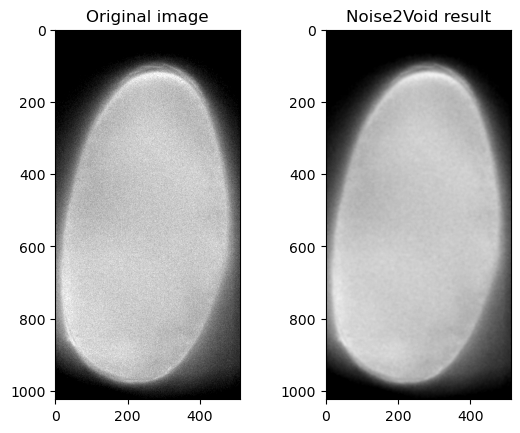

In [39]:
fig, axes = plt.subplots(ncols=2)

axes[0].imshow(data[40, :, :], cmap='gray', vmin=vmin, vmax=vmax)
axes[0].set_title('Original image')

axes[1].imshow(denoised_image[40, :, :], cmap='gray', vmin=vmin, vmax=vmax)
axes[1].set_title('Noise2Void result')

Text(0.5, 1.0, 'Noise2Void result')

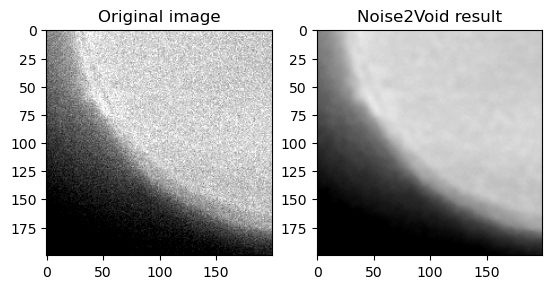

In [40]:
fig, axes = plt.subplots(ncols=2)

axes[0].imshow(data[40, 800:1000, 0:200], cmap='gray', vmin=vmin, vmax=vmax)
axes[0].set_title('Original image')

axes[1].imshow(denoised_image[40, 800:1000, 0:200], cmap='gray', vmin=vmin, vmax=vmax)
axes[1].set_title('Noise2Void result')

In [41]:
stackview.curtain(data[40], denoised_image[40], zoom_factor=0.5)